# Processing Seismic Waveform Data with `obspy` and `csp`

## Introduction

Seismic waves are vibrations that travel through the Earth, caused by earthquakes and volcano eruptions, among other causes. Seismic waves are recorded by seismometers located in seismic stations which are operated as a part of larger [networks](https://www.fdsn.org/networks/) of such stations. There are also [data centers](https://www.fdsn.org/datacenters/) that make data available to the public both historically and as a live feed via the [SeedLink](https://docs.fdsn.org/projects/seedlink/en/latest/) protocol. For more information about seismometers, seismographs and seismograms, see the [USGS FAQ](https://www.usgs.gov/faqs/seismometers-seismographs-seismograms-whats-difference-how-do-they-work).

The python library [`obspy`](https://docs.obspy.org/index.html) is a convenient tool for processing seismological data, including [waveform data](https://docs.obspy.org/packages/obspy.core.html#waveform-data). It provides clients to help access the data from python as well as signal processing functions that help with filtering and event detection (triggering) based on this time series data. Most routines operate on historical time series data represented as numpy arrays. 

In this notebook, our goal is to show how `csp` can be used to wrap functionality from `obspy` to access both real time and historical waveform data. We also illustrate how the filtering and triggering logic can be re-implemented in a way that applies just as easily to real time streaming data as it does to batch historical data.

Before we start, we import the relevant libraries. Note that you must have `obspy` and `scipy` installed in addition to `csp` to run this notebook.

In [1]:
import csp
import logging
import numpy as np
import pandas as pd
import sys
import warnings
from csp import ts
from datetime import timedelta, datetime
from obspy import read, Trace, Stream, UTCDateTime
from scipy.signal import iirfilter, sosfilt, zpk2sos
from typing import Dict, List, Optional, Tuple

warnings.filterwarnings('ignore') 

Now we can load the sample waveform "Stream" from obspy (i.e. a group of waveforms), and pull a single "Trace" from it:

In [2]:
st = read()
tr = st[0]
tr

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

The "id" of the Trace object is composed of the network id ("BW"), the station id ("RJOB") and the channel ("EHZ"). The channel names are composed of the band code (i.e. frequency, where "E" is "Extremely High Frequency"), the instrument code ("H" is "High Gain Seismometer") and the orientation code (i.e. "Z" is vertical movement). You can read more about channel naming [here](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/).

The trace has two main attributes, "stats" which contains metadata such as the start/end time, sampling frequency, etc and "data" which is a numpy array of the raw measurements, at equally sampled intervals in the time range.

In [3]:
tr.stats

         network: BW
         station: RJOB
        location: 
         channel: EHZ
       starttime: 2009-08-24T00:20:03.000000Z
         endtime: 2009-08-24T00:20:32.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
    back_azimuth: 100.0
     inclination: 30.0
        response: Channel Response
	From M/S (Velocity in Meters Per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 2.5168e+09 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.67785e+06
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1

In [4]:
tr.data

array([0.        , 0.00694644, 0.07597424, ..., 1.93449584, 0.98196204,
       0.44196924])

## Simulation
In real-time, trace data will be sent in batches of observations, so we can use csp to simulate this by writing a node that divides a stream into fixed size chunks for each interval. We can also simulate a lag in the transmitted data, as we would see in realtime event processing. 

In [5]:
@csp.graph
def trace_sim(stream: Stream, interval: timedelta, lag: timedelta = timedelta(0)) -> Dict[str, ts[Trace]]:
    out = {}
    for trace in stream:
        # Approximate number of equal intervals. This could be improved by using .slice over time intervals
        num_intervals = int((trace.stats.endtime - trace.stats.starttime) / interval.total_seconds())
        # Create a new stream of the split trace
        if num_intervals > 1:
            trace_stream = trace / num_intervals
        else:
            trace_stream = Stream(trace)
        # Create a curve of the trace that ticks some lag after the end time
        out[trace.id] = csp.curve(Trace, [(t.stats.endtime.datetime + lag, t) for t in trace_stream])
    return out

We can now run this simple graph to show how the pieces are divided into 5 second chunks with a small simulated transmission delay. Since the sample stream contains Traces for three different channels (corresponding to the N, E and Z dimensions), we will see three updates for every timestamp. 

In [6]:
@csp.graph
def print_slices(st: Stream, lag: timedelta):
    sim = trace_sim(st, interval=timedelta(seconds=5), lag=lag)
    for k, tr in sim.items():
        csp.print(f"Received simulated trace {k}", tr)

starttime = st[0].stats.starttime.datetime
csp.run(print_slices, st, lag=timedelta(seconds=0.01), starttime=starttime)

2009-08-24 00:20:09 Received simulated trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:09 Received simulated trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:09 Received simulated trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Received simulated trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Received simulated trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Received simulated trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:21 Received simulated trace BW.RJOB..EHZ:BW.RJOB..EHZ

We can also cheat, and pretend that this data is arriving in real time by delaying it until the current time:

In [7]:
csp.run(print_slices, st, lag=datetime.utcnow()-starttime, starttime=datetime.utcnow(), endtime=timedelta(seconds=30), realtime=True)

2024-06-06 13:39:28.921738 Received simulated trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:28.921738 Received simulated trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:28.921738 Received simulated trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:34.921738 Received simulated trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:34.921738 Received simulated trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:34.921738 Received simulated trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2024-06-06 13:39:40.921738 R

## Analytics

### Filtering
With waveform data coming in chunks in both historical and real time runs, we can use csp to implement filtering logic leveraging scipy. Here we illustrate a simple bandpass filter, but this could easily be generalized to other filter types.
Note that since we want our filter node to be able to process Trace data with different sampling frequencies, we need to wait until the first observation to design the filter

In [8]:
@csp.node
def bandpass_filter_ts(trace: ts[Trace], freqmin: float, freqmax: float) -> ts[Trace]:
    with csp.state():
        s_zi = None
        s_sos = None
        s_df = None
    if csp.ticked(trace):
        if s_sos is None:  # Design the filter the first time we see a trace obser
            s_df = trace.stats.sampling_rate
            z, p, k = iirfilter(4, [2*freqmin/s_df, 2*freqmax/s_df],  btype="band", ftype="butter", output="zpk")
            s_sos = zpk2sos(z, p, k)
            s_zi = np.zeros((s_sos.shape[0], 2))
        else:
            if trace.stats.sampling_rate != s_df:  # Validate that the sampling frequency hasn't changed!
                raise ValueError("Cannot change sampling rate")
        out, s_zi = sosfilt(s_sos, trace.data, zi=s_zi)
        return Trace(out, trace.stats)

Given the node above that defines a filter, we can now run it on the simulated data we used before

In [9]:
@csp.graph
def print_filtered_slices(st: Stream, freqmin: float, freqmax: float):
    sim = trace_sim(st, interval=timedelta(seconds=5), lag=timedelta(seconds=0.01))
    for k, tr in sim.items():
        filtered = bandpass_filter_ts(tr, freqmin, freqmax)
        csp.print(f"Calculated filtered trace {k}", filtered)
        csp.add_graph_output(k, filtered)

freqmin = 1
freqmax = 20
st = read()
starttime = st[0].stats.starttime.datetime
filter_out = csp.run(print_filtered_slices, st, freqmin=freqmin, freqmax=freqmax, starttime=starttime)

2009-08-24 00:20:09 Calculated filtered trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:09 Calculated filtered trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:09 Calculated filtered trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Calculated filtered trace BW.RJOB..EHZ:BW.RJOB..EHZ | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Calculated filtered trace BW.RJOB..EHN:BW.RJOB..EHN | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Calculated filtered trace BW.RJOB..EHE:BW.RJOB..EHE | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:21 Calculated filtered trace BW.RJOB..EHZ:BW.RJ

#### Comparison
How can we compare the filtered time series of observations with the native lowpass filter functionality that comes with `obspy` that operates on a single Trace? 

First we need to collect the pieces back into a single Trace. We could write a csp node that maintains a `Trace` with all the past history, but to keep things simple, we will just collect it in post-processing

In [10]:
st_filt_csp = Stream([Stream([v[1] for v in values]).merge()[0] for names, values in filter_out.items()])

Now we can compute the same filter using the native `obspy` function

In [11]:
st_filt_obspy = st.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax)

...and lastly we check that they match!

In [12]:
for i in range(len(st)):
    np.testing.assert_array_equal(st_filt_csp[i].data, st_filt_obspy[i].data)

### Triggering

Triggering is used for seismic event detection. See the `obspy` [documentation](https://docs.obspy.org/packages/obspy.signal.html#trigger) for an example of how to do this in a batch context.

A very simple methodology is to take the ratio of long term and short term moving averages of the magnitudes of the signal (i.e. STA/LTA), called the "characteristic function". We can use the functionality in `csp.stats` to implement this:

In [13]:
@csp.graph
def sta_lta_ts(trace: ts[Trace], nsta: int, nlta: int) -> ts[float]:
    # In the line below, we extract the data from each Trace mini-batch and "unroll" the data so that we can process it in sequence with csp.
    # Thus, on each tick of trace we will immediately process a batch of the past observations, but one at a time. 
    inputs = csp.unroll(csp.apply(trace, lambda tr: tr.data.tolist(), List[float]))
    square = inputs**2
    sta = csp.stats.ema(square, alpha=1./nsta, min_periods=nlta, adjust=False)
    lta = csp.stats.ema(square, alpha=1./nlta, min_periods=nlta, adjust=False)
    # (Optional) Return zero if sta/lta hasn't ticked yet (due to the window not being full). We do this to reconcile more closely with the obspy behavior. 
    return csp.merge(sta/lta, csp.sample(square, csp.const(0)))

With the sta_lta_ts graph defined above, we can test it out against the example from obspy. 

First, we set up the parameters:

In [14]:
st = read()
tr = st.select(component="Z")[0]
sta = 0.5
lta = 4
nsta = int(sta * tr.stats.sampling_rate)
nlta = int(lta * tr.stats.sampling_rate)

Now we compute the characteristic function using a `csp`-based approach.

Here we define the edges outside the graph, and run the characteristic function edge with `csp.run` and use the option `output_numpy` to put the sequence of results in a numpy array, so it can be directly compared with the `obspy` batch approach. However, note that because we are running the logic through the csp engine, even though we are comparing batch outputs, csp will be able to produce intermediate outputs as soon as they are available, which is required for real-time.

In [15]:
starttime = st[0].stats.starttime.datetime
tr_filt = bandpass_filter_ts(
        trace_sim(
            st, 
            interval=timedelta(seconds=5),  # Assume we receive new data every 5 seconds 
            lag=timedelta(seconds=0.01))["BW.RJOB..EHZ"], # Assume data is delayed some tiny amount
        freqmin=1, 
        freqmax=20)
timestamps_csp, cft_csp = csp.run(sta_lta_ts(tr_filt, nsta, nlta), starttime=starttime, output_numpy=True)[0]

#### Comparison
Now we compute the same thing via the `obspy` batch approach:

In [16]:
from obspy.signal.trigger import recursive_sta_lta_py
tr = tr.copy().filter("bandpass", freqmin=1, freqmax=20)  
cft = recursive_sta_lta_py(tr.data, nsta, nlta)

We do a quick plot of both characteristic functions to see how closely they match:

<Axes: >

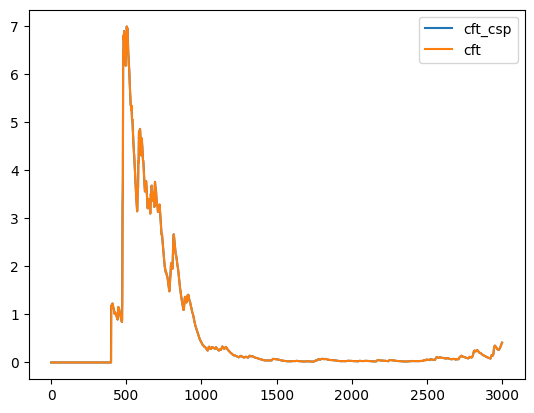

In [17]:
pd.DataFrame({"cft_csp":cft_csp, "cft":cft}).plot()

It is now very straightforward to write the actual triggering logic based on the characteristic function in csp; logic that will work just as well in real time as on historical data

In [18]:
@csp.node
def trigger_node(cft: ts[float], thrOn: float, thrOff: float) -> ts[bool]:
    with csp.state():
        s_on: bool = False
    if not s_on and cft > thrOn:
        s_on = True
        return s_on
    elif s_on and cft< thrOff:
        s_on = False
        return s_on

Given some thresholds, we can now run this (in simulation mode) and print the status of the trigger when it changes

In [19]:
thrOn = 4
thrOff = 0.7
@csp.graph
def print_trace_and_trigger(tr_filt: ts[Trace]):
    csp.print("Trace", tr_filt)
    csp.print("Trigger On?", trigger_node(sta_lta_ts(tr_filt, nsta, nlta), thrOn, thrOff))
csp.run(print_trace_and_trigger, tr_filt, starttime=starttime)

2009-08-24 00:20:09 Trace:BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:08.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:09 Trigger On?:True
2009-08-24 00:20:15 Trace:BW.RJOB..EHZ | 2009-08-24T00:20:09.000000Z - 2009-08-24T00:20:14.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:15 Trigger On?:False
2009-08-24 00:20:21 Trace:BW.RJOB..EHZ | 2009-08-24T00:20:15.000000Z - 2009-08-24T00:20:20.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:27 Trace:BW.RJOB..EHZ | 2009-08-24T00:20:21.000000Z - 2009-08-24T00:20:26.990000Z | 100.0 Hz, 600 samples
2009-08-24 00:20:33 Trace:BW.RJOB..EHZ | 2009-08-24T00:20:27.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 600 samples


Note that we will only be notified of trigger changes when we receive a new Trace update with a batch of data. In this case, we have divided up the trace observations into 5 second intervals, so our detection will not be more granular than that. We could also look at the timestamps within the Trace to find exactly when the condition changed, but it would not change the time that we learn about it given how data is transmitted.

This is an important consideration when using historical data to design real-time algorithms. By only analyzing the batch data, one might accidentally make assumptions about how quickly you can respond to changing conditions that are not possible in actuality. With a tool like `csp`, it is easy to simulate/model how data arrives in real time for historical analysis, which leads to a closer correspondence between research and live usage.

For comparison, below is the trigger chart produced by `obspy`. Note that it turns "On" at approximately `00:20:08` and off at approximately `00:20:13` (i.e. 5 and 10 seconds after `00:20:03`, the Trace start time).

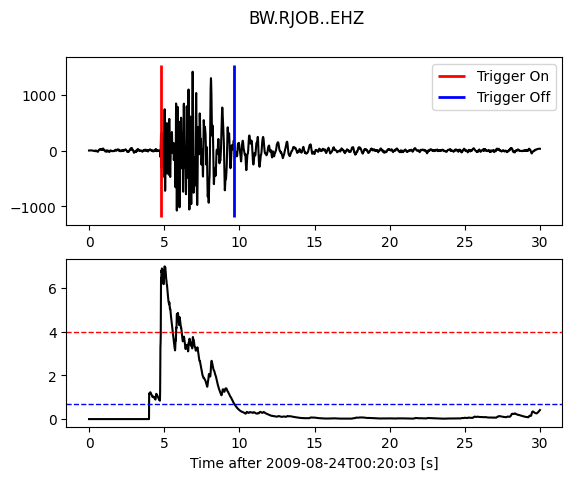

In [20]:
from obspy.signal.trigger import plot_trigger, trigger_onset
thrOn = 4
thrOff = 0.7
plot_trigger(tr, cft, thrOn, thrOff) 

## Historical Data
In this section, we build a simple graph to pull historical data from FDSN and feed it through csp. It is straightforward to apply the filtering and triggering logic from the previous section to these outputs.

In [21]:
from obspy.clients.fdsn import Client

@csp.graph
def fdsn_waveforms(
    client: Client,
    network: str,
    station: str,
    location: str,
    channel: str,
    interval: timedelta,
    lag: timedelta = timedelta(0),
    starttime: Optional[datetime] = None,
    endtime: Optional[datetime] = None,
    quality: Optional[str] = None,
    minimumlength: Optional[str] = None,
    longestonly: Optional[bool] = None,
    attach_response: bool = False,
) -> Dict[str, ts[Trace]]:
    """Wraps the get_waveform function in obspy behind a csp adapter. Waveforms are divided into periods of length given
    by interval, to simulate "real time" arrival
    https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html#obspy.clients.fdsn.client.Client.get_waveforms
    """
    starttime = UTCDateTime(starttime or csp.engine_start_time())
    endtime = UTCDateTime(endtime or csp.engine_end_time())
    stream = client.get_waveforms(
        network,
        station,
        location,
        channel,
        starttime,
        endtime,
        quality=quality,
        minimumlength=minimumlength,
        longestonly=longestonly,
        attach_response=attach_response,
    )
    return trace_sim(stream, interval=interval, lag=lag)

In [22]:
client = Client("IRIS")
t = UTCDateTime("2012-12-14T10:36:01.6Z")
starttime = (t + 300).datetime
endtime = (t + 400).datetime
@csp.graph
def graph():
    basket = fdsn_waveforms(client, "TA", "E42A", "*", "BH?", timedelta(seconds=4))
    for k, v in basket.items():
        csp.print(k, v)

out = csp.run(graph, starttime=starttime, endtime=endtime)

2012-12-14 10:41:05.774998 TA.E42A..BHE:TA.E42A..BHE | 2012-12-14T10:41:01.624998Z - 2012-12-14T10:41:05.774998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:05.774998 TA.E42A..BHN:TA.E42A..BHN | 2012-12-14T10:41:01.624998Z - 2012-12-14T10:41:05.774998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:05.774998 TA.E42A..BHZ:TA.E42A..BHZ | 2012-12-14T10:41:01.624998Z - 2012-12-14T10:41:05.774998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:09.949998 TA.E42A..BHE:TA.E42A..BHE | 2012-12-14T10:41:05.799998Z - 2012-12-14T10:41:09.949998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:09.949998 TA.E42A..BHN:TA.E42A..BHN | 2012-12-14T10:41:05.799998Z - 2012-12-14T10:41:09.949998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:09.949998 TA.E42A..BHZ:TA.E42A..BHZ | 2012-12-14T10:41:05.799998Z - 2012-12-14T10:41:09.949998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:14.124998 TA.E42A..BHE:TA.E42A..BHE | 2012-12-14T10:41:09.974998Z - 2012-12-14T10:41:14.124998Z | 40.0 Hz, 167 samples
2012-12-14 10:41:14.124998 TA.E42A..BHN:TA.E42A.

## Real-time Data via Seedlink
In this section, we build a real time adapter to live waveform data. It is straightforward to apply the filtering and triggering logic from the previous section to these outputs.

### Real-time Adapter Definition

In [23]:
import logging
import threading
from fnmatch import fnmatch
from obspy.clients.seedlink.client.seedlinkconnection import SeedLinkConnection
from obspy.clients.seedlink.client.slstate import SLState
from obspy.clients.seedlink.slpacket import SLPacket
from urllib.parse import urlparse

from csp.impl.adaptermanager import AdapterManagerImpl
from csp.impl.pushadapter import PushInputAdapter
from csp.impl.wiring import py_push_adapter_def


class EasySeedLinkAdapter:
    """Real time adapter (technically an adapter manager of push adapters) that manages subscription to multiple seedlink streams for the same connection. """
    
    def __init__(self, server_url: str):
        """ Constructor
        
        Args:
            server_url: The url and port of the seedlink server we connect to.
        """
        self._server_url = server_url
        
        self._server_url = server_url
        parsed_url = urlparse(server_url, scheme="seedlink")
        self._conn = SeedLinkConnection()
        self._conn.set_sl_address("%s:%d" % (parsed_url.hostname, parsed_url.port or 18000))

        # We will keep track of requested input adapters here
        self._inputs = {}

        # Out driving thread, all  realtime adapters will need a separate thread of execution that drives data into the engine thread
        self._running = False
        self._thread = None
        self._starttime = None
        self._endtime = None

    def subscribe(self, network, station, selector=None, push_mode=csp.PushMode.NON_COLLAPSING):
        """User facing API to subscribe to a timeseries stream from this adapter manager"""
        # This will return a graph-time timeseries edge representing and edge from this adapter manager for the given symbol / arguments
        return _easy_seedlink_adapter(self, network, station, selector, push_mode=push_mode)

    def _create(self, engine, memo):
        """This method will get called at engine build time, at which point the graph time manager representation
        will create the actual impl that will be used for runtime
        """
        return _EasySeedLinkAdapterManagerImpl(engine, self._server_url)


class _EasySeedLinkAdapterManagerImpl(AdapterManagerImpl):
    """ This is the implementation of the Adapter Manager, which is shared across multiple adapter implementations """
    
    def __init__(self, engine, server_url: str):
        super().__init__(engine)
        parsed_url = urlparse(server_url, scheme="seedlink")
        self._conn = SeedLinkConnection()
        self._conn.set_sl_address("%s:%d" % (parsed_url.hostname, parsed_url.port or 18000))

        # We will keep track of requested input adapters here
        self._inputs = {}

        # Out driving thread, all  realtime adapters will need a separate thread of execution that drives data into the engine thread
        self._running = False
        self._thread = None
        self._starttime = None
        self._endtime = None
        
    def start(self, starttime, endtime):
        """start will get called at the start of the engine run.  At this point one would start up the realtime data source / spawn the driving 
        thread(s) and subscribe to the needed data"""
        self._running = True
        self._starttime = starttime
        self._endtime = endtime
        # Set the start time on the connection, in case it is in the past
        self._conn.set_begin_time(UTCDateTime(starttime))
        self._conn.set_end_time(UTCDateTime(endtime))
        self._thread = threading.Thread(target=self._run)
        self._thread.start()

    def stop(self):
        """This will be called at the end of the engine run, at which point resources should be closed and cleaned up"""
        if self._running:            
            self._running = False
            self._thread.join()

    def register_input_adapter(self, network, station, selector, adapter):
        """Actual PushInputAdapters will self register when they are created as part of the engine
        This is the place we gather all requested input adapters and their properties
        """
        symbol = (network, station, selector)
        if symbol not in self._inputs:
            self._inputs[symbol] = []
        # Keep a list of adapters by key in case we get duplicate adapters ( should be memoized in reality )
        self._inputs[symbol].append(adapter)

    def process_next_sim_timeslice(self, now):
        """This method is only used by simulated / historical adapters, for realtime we just return None"""
        return None

    def _run(self):
        """Our driving thread, in reality this will be reacting to external events, parsing the data and pushing it into the respective adapter"""
        # Connect
        self._conn.connect()
        self._conn.state.state = SLState.SL_UP

        # Add streams
        for network, station, selector in self._inputs:
            self._conn.add_stream(network, station, selector, seqnum=-1, timestamp=None)

        while self._running:
            data = self._conn.collect()
            if data == SLPacket.SLTERMINATE:
                break
            elif data == SLPacket.SLERROR:
                continue
                
            if data.get_type() not in (SLPacket.TYPE_SLINF, SLPacket.TYPE_SLINFT):
                trace = data.get_trace()
                for (network, station, selector), adapters in self._inputs.items():
                    if (
                        fnmatch(trace.stats.network, network)
                        and fnmatch(trace.stats.station, station)
                        and (selector and fnmatch(trace.stats.channel, selector))
                    ):
                        for adapter in adapters:
                            adapter.push_tick(trace)
        self._conn.close()


class _EasySeedLinkAdapterImpl(PushInputAdapter):
    """Our input adapter is a very simple implementation, and just defers its work back to the manager who is expected to deal with sharing a single connection."""
    def __init__(self, manager_impl, network, station, selector):
        manager_impl.register_input_adapter(network, station, selector, self)
        super().__init__()


_easy_seedlink_adapter = py_push_adapter_def(
    name="_easy_seedlink_adapter",
    adapterimpl=_EasySeedLinkAdapterImpl,
    out_type=ts[Trace],
    manager_type=EasySeedLinkAdapter,
    network=str,
    station=str,
    selector=str,
)

### Real-time Adapter Usage

Now that we've defined the adapter, we demonstrate it's use before. For simplicity, we just output the raw trace data, but note that our adapter supports wildcard subscriptions to make it easier to subscribe to multiple channels and stations at once! Note how the data arrives in mini-batches of trace, similar to how we simulated it above. One major difference is that the batches are not all exactly the same length, even for the same channel. However, none of the logic we implemented for triggering/filtering assumes that the batches are of equal length. 

In [24]:
@csp.graph
def rt_graph(address: str, symbols: List[Tuple[str, str, Optional[str]]]):
    adapter_manager = EasySeedLinkAdapter(address)
    for symbol in symbols:
        data = adapter_manager.subscribe(*symbol)
        csp.log(logging.INFO, f"{symbol}", data)

In [25]:
# Connect to the iris seedlink server, which covers many US stations
address = "http://rtserve.iris.washington.edu:18000"
symbols = [("LD", "PAL", "??Z"), ("LD", "CUNY", "??Z")]  # Palisades, NY and Queens College, CUNY, NY 
# Could also subscribe to station via wildcard, to get a given channel from all available stations!
#symbols = [("LD", "*", "HHZ")]

logging.basicConfig(stream=sys.stdout, format="[%(asctime)s] %(levelname)s: %(message)s", level=logging.INFO)
csp.run(
    rt_graph,
    address,
    symbols,
    starttime=datetime.utcnow() - timedelta(seconds=60),
    endtime=timedelta(seconds=120),
    realtime=True,
)

[2024-06-06 09:39:56,603] INFO: network socket opened
[2024-06-06 09:39:56,792] INFO: connected to: 'SeedLink v3.1 (2020.075 RingServer) :: SLPROTO:3.1 CAP EXTREPLY NSWILDCARD BATCH WS:13'
[2024-06-06 09:39:56,936] INFO: requesting specified time window
[2024-06-06 09:39:57,146] INFO: requesting specified time window
[2024-06-06 09:39:57,217] INFO: 2 station(s) accepted
[2024-06-06 09:39:57,299] INFO: 2024-06-06 13:39:57.299195 ('LD', 'PAL', '??Z'):LD.PAL..HNZ | 2024-06-06T13:38:54.124538Z - 2024-06-06T13:38:57.239538Z | 200.0 Hz, 624 samples
[2024-06-06 09:39:57,301] INFO: 2024-06-06 13:39:57.301867 ('LD', 'PAL', '??Z'):LD.PAL..HNZ | 2024-06-06T13:38:57.244538Z - 2024-06-06T13:39:00.289538Z | 200.0 Hz, 610 samples
[2024-06-06 09:39:57,305] INFO: 2024-06-06 13:39:57.305381 ('LD', 'PAL', '??Z'):LD.PAL..HNZ | 2024-06-06T13:39:00.294538Z - 2024-06-06T13:39:03.399538Z | 200.0 Hz, 622 samples
[2024-06-06 09:39:57,307] INFO: 2024-06-06 13:39:57.307313 ('LD', 'PAL', '??Z'):LD.PAL..HNZ | 2024-

Also note that the log timestamp (in local time) is very close to the csp timestamp (in utc time), but that we actually receive multiple traces at nearly the same time for a given channel, spanning the time since the previous group was received. This is an artifact of this particular server - other servers behave differently. 

Furthermore, note that because we started the csp graph 60 seconds in the past, the server has sent us a number of past observations at the start of our run, before sending us the live data. This can be useful behavior when running stateful analytics (such as moving averages) that need to be "warmed up".

### Real-time Triggering
To illustrate how the filtering/triggering logic would apply in real-time, we compute the trigger characteristic function for the "HHZ" channel. To limit the amount of output, instead of outputting every tick, we compute the max over regular intervals and output that. 

In [26]:
@csp.graph
def rt_graph_trigger(address: str, symbols: List[Tuple[str, str, str]], nsta: int, nlta: int):
    adapter_manager = EasySeedLinkAdapter(address)
    for symbol in symbols:
        data = adapter_manager.subscribe(*symbol)
        csp.log(logging.INFO, f"Raw data:", data)
        tr_filt = bandpass_filter_ts(data, freqmin=1, freqmax=20)
        cft = sta_lta_ts(tr_filt, nsta, nlta)
        # Because on each tick of "data", we generate several values of "cft" by unrolling the observations, we want to trigger reporting of the maxim cft over each batch
        trigger = csp.delay(data, timedelta.resolution)
        min_cft = csp.stats.min(cft, trigger=trigger, reset=data)
        max_cft = csp.stats.max(cft, trigger=trigger, reset=data)        
        csp.log(logging.INFO, f"Characteristic function for {symbol}, Min", min_cft)
        csp.log(logging.INFO, f"Characteristic function for {symbol}, Max", max_cft)

For this example, we use a station on the Canadian (i.e. "CN") network, as the high frequency channel will publish updates every 4-5 seconds, which is more rapid than the IRIS network used above. However, occasionally the connection to this network can time out, in which case, please try again later. When it's working properly, a log line containing `INFO: network socket opened` should appear almost immediately.
The [GEOFON network](https://geofon.gfz-potsdam.de/waveform/seedlink.php) (http://geofon.gfz-potsdam.de:18000) is also a good alternative choice, i.e. channel ("GE", "STU", "HHZ"). 

In [27]:
address = "http://earthquakescanada.nrcan.gc.ca:18000"
symbols = [("CN", "QEPB", "HHZ")]  # Queen Elizabeth Park in Vancouver, BC
sampling_rate = 100  # HHZ is sampled at 100Hz
sta = 0.5
lta = 4
nsta = int(sta * sampling_rate)
nlta = int(lta * sampling_rate)

csp.run(
    rt_graph_trigger,
    address,
    symbols,
    nsta,
    nlta,
    starttime=datetime.utcnow() - timedelta(seconds=10),  # Starting in the past helps "warm up" the averages
    endtime=datetime.utcnow() + timedelta(seconds=60),
    realtime=True,
)

[2024-06-06 09:40:57,094] INFO: network socket opened
[2024-06-06 09:40:57,258] INFO: connected to: 'SeedLink v3.1 (2015.188 Ring Server SeedLink) :: SLPROTO:3.1 CAP EXTREPLY NSWILDCARD BATCH'
[2024-06-06 09:40:57,405] INFO: requesting specified time window
[2024-06-06 09:40:57,483] INFO: 1 station(s) accepted
[2024-06-06 09:41:12,363] INFO: 2024-06-06 13:41:12.363172 Raw data::CN.QEPB..HHZ | 2024-06-06T13:40:44.270000Z - 2024-06-06T13:40:47.580000Z | 100.0 Hz, 332 samples
[2024-06-06 09:41:12,373] INFO: 2024-06-06 13:41:12.363173 Characteristic function for ('CN', 'QEPB', 'HHZ'), Min:0.0
[2024-06-06 09:41:12,376] INFO: 2024-06-06 13:41:12.363173 Characteristic function for ('CN', 'QEPB', 'HHZ'), Max:0.0
[2024-06-06 09:41:12,377] INFO: 2024-06-06 13:41:12.377614 Raw data::CN.QEPB..HHZ | 2024-06-06T13:40:47.590000Z - 2024-06-06T13:40:50.800000Z | 100.0 Hz, 322 samples
[2024-06-06 09:41:12,383] INFO: 2024-06-06 13:41:12.377615 Characteristic function for ('CN', 'QEPB', 'HHZ'), Min:0.0
[2

## Conclusion

In this notebook we :
* illustrated how to take historical Trace data in `obspy` and represent it as a stream of smaller Trace updates using `csp`
* implemented filtering and triggering analytics using csp that match the equivalent functions in `obspy`
* showed how to pull real historical Trace data into `csp` to test these analytics as part of research
* demonstrated how to run the same analytics on streaming Trace data using the real time `csp` engine